In [ ]:
import os 
os.environ['KAGGLE_CONFIG_DIR']='/content'
!chmod 600 /content/kaggle.json
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database
!unzip \*.zip && rm *.zip

In [ ]:
%matplotlib inline
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os
import glob
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, MaxPooling2D, Flatten, Activation, LayerNormalization, Softmax
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score
import seaborn as sns
from keras.callbacks import ModelCheckpoint
from keras import models

In [ ]:
def prepare_input(filename):
  images = glob.glob(filename)
  imgs = np.array([cv2.resize(cv2.imread(file,0),(227,227)) for file in images])
  imgs=imgs.reshape(-1,227,227,1)
  #imgs=imgs[:,:,:,:1]
  return imgs

In [ ]:
covid_imgs = prepare_input('/content/COVID-19_Radiography_Dataset/COVID/*.png')
normal_imgs = prepare_input('/content/COVID-19_Radiography_Dataset/Normal/*.png')
print(covid_imgs.shape)
print(normal_imgs.shape)

(3616, 227, 227, 1)
(10192, 227, 227, 1)


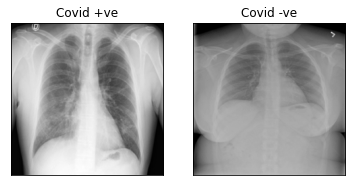

In [ ]:
plt.subplot(1,2,1),
plt.imshow(covid_imgs[0].reshape(227,227),cmap='gray')
plt.xticks([]), plt.yticks([])
plt.title('Covid +ve')
plt.subplot(1,2,2)
plt.imshow(normal_imgs[0].reshape(227,227),cmap='gray')
plt.xticks([]), plt.yticks([])
plt.title('Covid -ve')
plt.show()

In [ ]:
full_data=np.vstack((covid_imgs,normal_imgs))
print(full_data.shape)

(13808, 227, 227, 1)


In [ ]:
y_data=np.concatenate((np.ones(len(covid_imgs)),np.zeros(len(normal_imgs))))
print(y_data.shape)

(13808,)


In [ ]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=36)
for train_index, test_index in sss.split(full_data, y_data):
 X_train = full_data[train_index]
 y_train= y_data[train_index]
 X_test = full_data[test_index]
 y_test= y_data[test_index]

In [ ]:
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(11046, 227, 227, 1)
(11046, 1)
(2762, 227, 227, 1)
(2762, 1)


In [ ]:
print(np.sum(y_train)/len(y_train))
print(np.sum(y_test)/len(y_test))

0.2619047619047619
0.2617668356263577


In [ ]:
model = Sequential()
model.add(Conv2D(96, kernel_size=(7,7),use_bias=True,strides=(4,4), padding='valid',input_shape=X_train[0].shape,activation='relu' ))
model.add(LayerNormalization())
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='valid'))
model.add(Conv2D(256, kernel_size=(5,5),strides=(1,1),use_bias=True,groups=2, padding='same',activation='relu' ))
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='valid'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(2))
model.add(Dense(1,activation='sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 56, 56, 96)        4800      
_________________________________________________________________
layer_normalization (LayerNo (None, 56, 56, 96)        192       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 256)       307456    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 256)       0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 256)       0         
_________________________________________________________________
flatten (Flatten)            (None, 43264)             0

In [ ]:
epochs = 40
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
history = model.fit(
  X_train,y_train,
  validation_data=(X_test,y_test),
  epochs=epochs,
  callbacks = [checkpoint],
  verbose = 0
)


Epoch 00001: val_accuracy improved from -inf to 0.83020, saving model to best_model.h5

Epoch 00002: val_accuracy improved from 0.83020 to 0.84540, saving model to best_model.h5

Epoch 00003: val_accuracy improved from 0.84540 to 0.89138, saving model to best_model.h5

Epoch 00004: val_accuracy improved from 0.89138 to 0.91383, saving model to best_model.h5

Epoch 00005: val_accuracy improved from 0.91383 to 0.91636, saving model to best_model.h5

Epoch 00006: val_accuracy improved from 0.91636 to 0.93917, saving model to best_model.h5

Epoch 00007: val_accuracy improved from 0.93917 to 0.94171, saving model to best_model.h5

Epoch 00008: val_accuracy improved from 0.94171 to 0.94859, saving model to best_model.h5

Epoch 00009: val_accuracy did not improve from 0.94859

Epoch 00010: val_accuracy improved from 0.94859 to 0.95257, saving model to best_model.h5

Epoch 00011: val_accuracy did not improve from 0.95257

Epoch 00012: val_accuracy did not improve from 0.95257

Epoch 00013: va

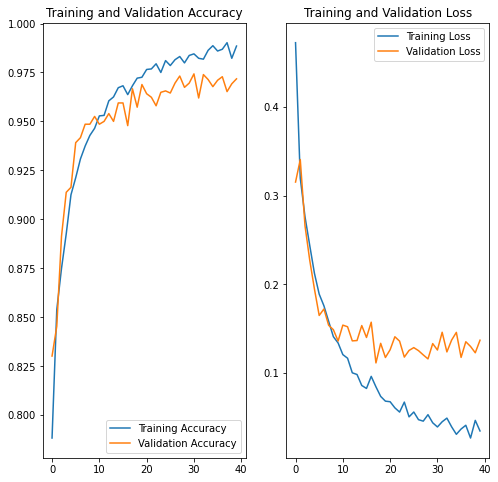

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# using the model at the best epoch
model.load_weights('best_model.h5')

In [ ]:
y_pred_value=model.predict(X_test)
y_pred = ( y_pred_value > 0.5).astype("int32")
print(y_pred)

[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [0]]


In [ ]:
print(accuracy_score(y_test,y_pred))

0.9742939898624186


In [ ]:
confusion_mat = confusion_matrix(y_test,y_pred)

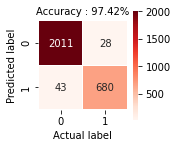

In [ ]:
plt.figure(figsize=(2,2))
sns.heatmap(confusion_mat, annot=True, fmt=".0f", linewidths=.2, square = True, cmap = 'Reds');
plt.ylabel('Predicted label');
plt.xlabel('Actual label');
all_sample_title = 'Accuracy : {}%'.format(int(accuracy_score(y_test,y_pred)*10000)/100)
plt.title(all_sample_title, size = 10);

In [ ]:
redef_model = models.Model(inputs=model.inputs, outputs=model.layers[1].output)

In [ ]:
feature_maps = redef_model.predict(full_data[0].reshape(-1,227,227,1))

In [ ]:
feature_maps.shape

(1, 56, 56, 96)

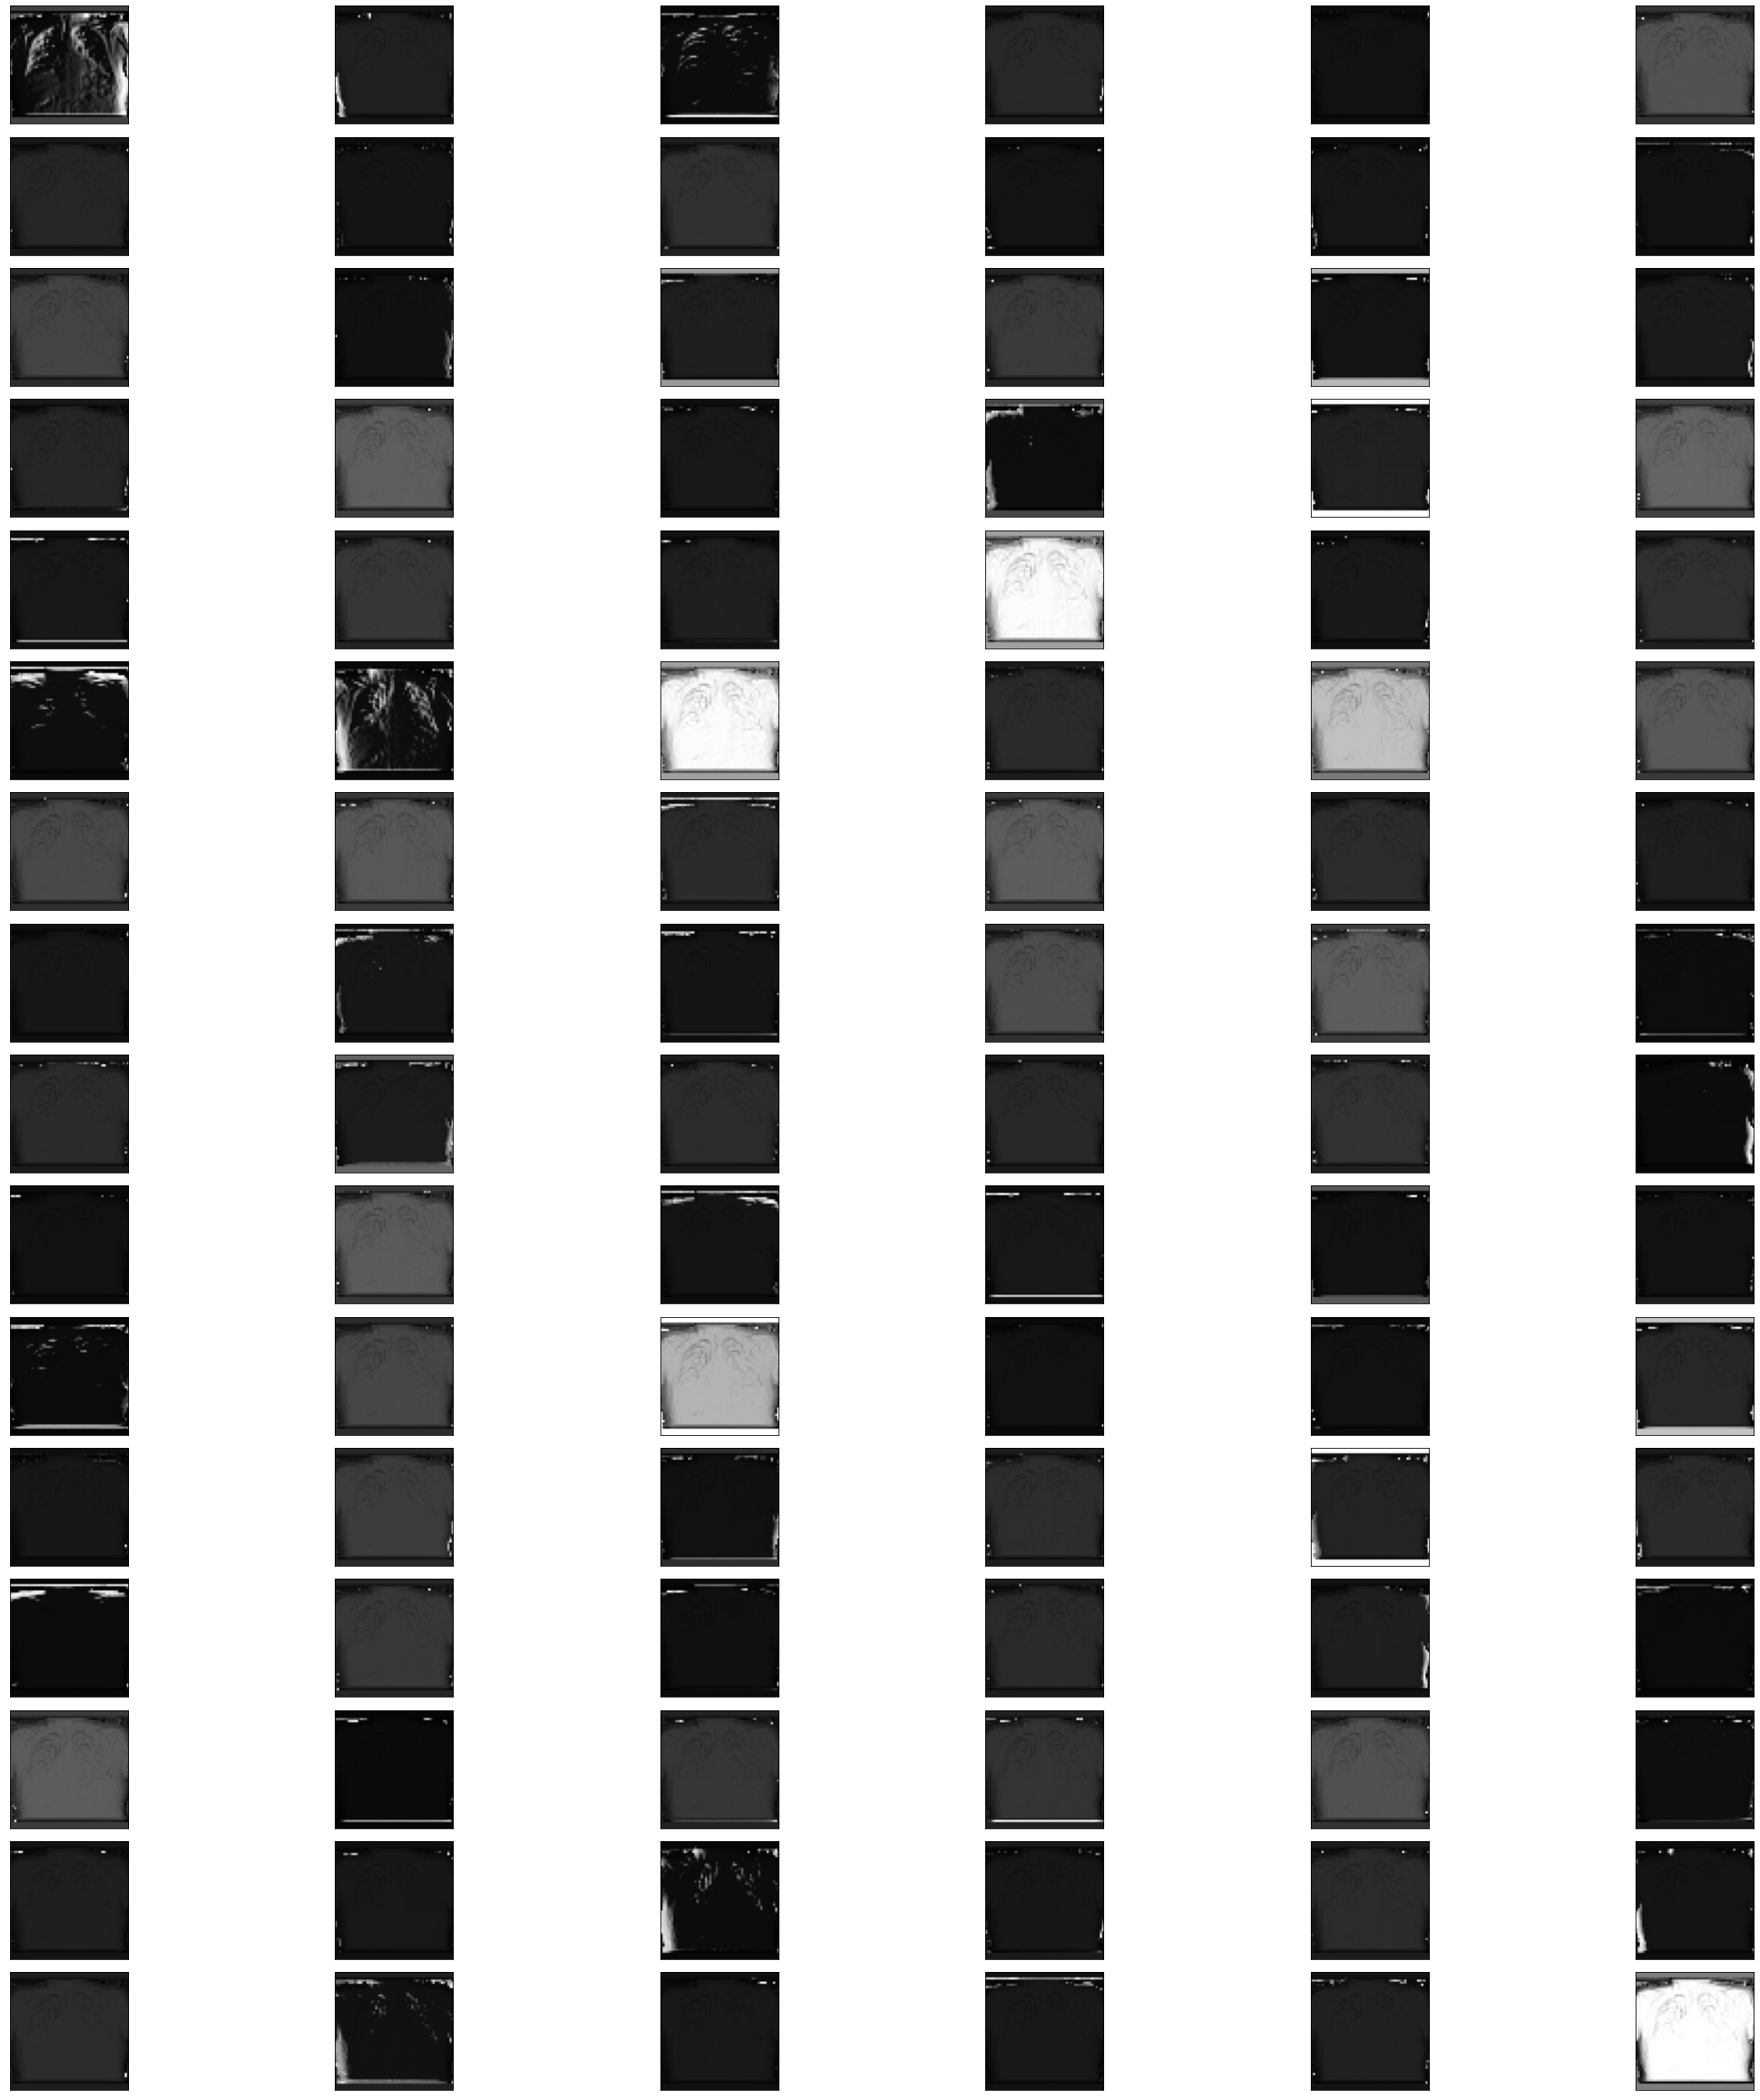

In [ ]:
columns = 6
rows = 16
num = 1
fig = plt.figure(figsize = (32,32))
for col in range(columns):
  for row in range(rows):
    fig.add_subplot(rows,columns,num)
    plt.xticks([]), plt.yticks([])
    plt.imshow(feature_maps[0, :, :, num-1], cmap='gray')
    num+=1
plt.tight_layout()
plt.show()

In [ ]:
acc = accuracy_score(y_test,y_pred)
precision = precision_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)
print("Accuracy : {}%".format(int(acc*10000)/100))
print("Precision : {}".format(precision))
print("Recall : {}".format(recall))

Accuracy : 97.42%
Precision : 0.96045197740113
Recall : 0.9405255878284924


In [ ]:
filter_covid= y_test==1
filter_normal= y_test==0
covid_pred= y_pred_value[filter_covid]
normal_pred= y_pred_value[filter_normal]

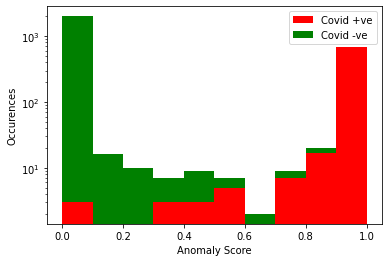

In [ ]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)  
plt.hist(x=[covid_pred,normal_pred],color=['r','g'],label=['Covid +ve','Covid -ve'],stacked=True)
plt.xlabel('Anomaly Score')
plt.ylabel('Occurences')
plt.yscale('log')
plt.legend()
plt.show()